<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [ ]:
URL = "http://www.indeed.com/jobs?"

In [37]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm_notebook

pd.set_option('display.max_colwidth',1000, 'display.max_columns',1000)

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [ ]:
## YOUR CODE HERE

def extract_title_from_result(result):
    try:
        return result.find('a', attrs={'class':'jobtitle', 'data-tn-element':'jobTitle'}).text.strip()
    except:
        np.nan
    
def extract_company_from_result(result):
    try:
        return result.find('span', attrs={'class':'company'}).text.strip()
    except:
        return np.nan
        
def extract_rating_from_result(result):
    try:
        return result.find('span', attrs={'class':'ratingsDisplay'}).text.strip()
    except:
        return np.nan
        
def extract_location_from_result(result):
    try:
        return result.find('span', attrs={'class':'location'}).text.strip()
    except:
        return np.nan

def extract_summary_from_result(result):
    try:
        return result.find('div', attrs={'class':'summary'}).text.strip()
    except:
        return np.nan

def extract_date_from_result(result):
    try:
        return result.find('span', attrs={'class':'date'}).text.strip()
    except:
        return np.nan

def extract_salary_from_result(result):
    try:
        return result.find('span', attrs={'class':'salaryText'}).text.strip()
    except:
        return np.nan
    
def calc_salary_USD_from_salary(result):
    try:
        return extract_salary_from_result(result)*fx_rate[str(city)]
    except:
        return extract_salary_from_result(result)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [ ]:
## YOUR CODE HERE

import re

UK_CITY = ['London', 'Edinburgh', 'Cambridge', 'Oxford', 'Manchester', 'Reading', 'Bristol', 'Belfast',
            'Leeds', 'Glasgow', 'Birmingham', 'Nottingham']
UK_FX_rate = 1.3

max_results_per_city = 5000
job_city = {}
run_count = 0

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 'Philadelphia',
                 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston',
                 'Miami'] + UK_CITY):
    
    title = []
    company = []
    rating = []
    search_city = []
    location = []
    salary = []
    age = []
    summary = []
    
    run_count+=1
    print('Searching City number: ', run_count)

    for occupation in set(['data scientist', 'data analyst', 'data analytics', 'data engineer',
                           'business intelligence', 'machine learning', 'artificial intelligence']): 
        old_page = 0
        print('Running: ', str(city),' & ',str(occupation))

        for page in tqdm_notebook(range(0, max_results_per_city, 10)):
            if city in UK_CITY:
                URL = "http://www.indeed.co.uk/jobs?"
                PARAMS = dict(as_phr=str(occupation), l=city, start=page)
            else:
                URL = "http://www.indeed.com/jobs?"
                PARAMS = dict(as_phr=str(occupation), l=city, start=page)

            r = requests.get(url=URL, params=PARAMS)
            soup = BeautifulSoup(r.text, 'html.parser')

            if soup.find('div', attrs={'id':'searchCountPages'}) == None:
                break
            else:
                new_page = int(re.findall(re.compile(r'\w+'), soup.find('div', attrs={'id':'searchCountPages'}).text.strip('\n'))[1])

                if new_page > old_page:
                    old_page = new_page
                    for posting in soup.find_all('div', attrs={'class':'result'}):
                        title.append(extract_title_from_result(posting))
                        company.append(extract_company_from_result(posting))
                        rating.append(extract_rating_from_result(posting))
                        search_city.append(city)
                        location.append(extract_location_from_result(posting))
                        salary.append(extract_salary_from_result(posting))
                        age.append(extract_date_from_result(posting))
                        summary.append(extract_summary_from_result(posting))
                else:
                    break

    # creating a df for that city's results and writing it to [insert city].csv...
    job_city_df = pd.DataFrame(dict(title=title,company=company,rating=rating,search_city=search_city,
                                    location=location,salary=salary,age=age,summary=summary))
    job_city_df.to_csv(str(city)+'.csv', index=False)
    
print('FINISHED')

In [ ]:
# Load in CSVs and create a dataframe from it:

jobs = pd.DataFrame()

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 'Philadelphia',
                 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston',
                 'Miami'] + UK_CITY):

    jobs_city = pd.read_csv(str(city)+'.csv')

    if 'Unnamed: 0' in pd.read_csv(str(city)+'.csv').columns: # to check if csv was saved with index (above)
        jobs_city.drop(columns=['Unnamed: 0'], inplace=True)
    else:
        break
    jobs = jobs.append(jobs_city, ignore_index=True)

print(jobs.shape)
jobs.head()

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [ ]:
## YOUR CODE HERE: adding salary frequencies, and restricting on yearly salaries, also dropping dupes.
jobs_salaried = jobs[jobs['salary'].notnull()]

# find and remove dupes first:
print('Total shape:',jobs_salaried.shape)
print('Duplicates:',jobs_salaried[jobs_salaried.duplicated()].shape)

jobs_salaried.drop_duplicates(inplace=True)
print('Any dupes left?:',jobs_salaried[jobs_salaried.duplicated()].shape)

# create salary_freq column and filter for only yearly salaries:
salary_freq = []
for sal in jobs_salaried['salary']:
    if 'year' in sal:
        salary_freq.append('year')
    elif 'month' in sal:
        salary_freq.append('month')
    elif 'week' in sal:
        salary_freq.append('week')
    elif 'day' in sal:
        salary_freq.append('day')
    elif 'hour' in sal:
        salary_freq.append('hour')
    else:
        salary_freq.append(np.nan)
        
jobs_salaried.insert(6, 'salary_freq', salary_freq)
print('Unique Salary Frequencies found:',jobs_salaried.salary_freq.unique())

jobs_salaried_year = jobs_salaried[jobs_salaried['salary_freq']=='year']
print('Checking only year remains:',jobs_salaried_year.salary_freq.unique())
print('Jobs Salaried Yearly:',jobs_salaried_year.shape)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [ ]:
## YOUR CODE HERE: creating salary_avg from salary ranges, and dollarizing UK salaries

import re
from re import sub
from decimal import Decimal

jobs_salaried_year.insert(7, 'isRange', jobs_salaried_year.apply(lambda x: 'Range' if '-' in x['salary'] else
                                                        'Not Range', axis=1))

salary_range_min = []
salary_range_max = []
salary_avg = []
salary_avg_USD = []

for x in jobs_salaried_year[['salary','isRange']].values:
    if x[1] == 'Not Range':
        salary_range_min.append(Decimal(sub(r'[^\d.]', '', x[0])))
        salary_range_max.append(Decimal(sub(r'[^\d.]', '', x[0])))
        salary_avg.append(Decimal(sub(r'[^\d.]', '', x[0])))

    if x[1] == 'Range':
        range_min = re.findall(r'[\d.,]+',x[0])[0]
        range_min = Decimal(sub(r',','',range_min))
        salary_range_min.append(range_min)
        
        range_max = re.findall(r'[\d.,]+',x[0])[1]
        range_max = Decimal(sub(r',','',range_max))
        salary_range_max.append(range_max)
        
        salary_avg.append((range_min+range_max)/2)
    
jobs_salaried_year.insert(8, 'salary_range_min', salary_range_min)
jobs_salaried_year.insert(9, 'salary_range_max', salary_range_max)
jobs_salaried_year.insert(10, 'salary_avg', salary_avg)

jobs_salaried_year.insert(11, 'salary_avg_USD',
                         jobs_salaried_year.apply(lambda x: round(Decimal(UK_FX_rate)*x['salary_avg'],2) 
                                                  if x['search_city'] in UK_CITY
                                                  else x['salary_avg'], axis=1))

jobs_salaried_year.head(1)

### Save your results as a CSV

In [ ]:
## YOUR CODE HERE: write to csv
jobs_salaried_year.to_csv('indeed_results.csv', index=False)

### Load in the the data of scraped salaries

In [58]:
## YOUR CODE HERE: load in indeed.csv
import pandas as pd
indeed = pd.read_csv('indeed_results.csv')

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [59]:
## YOUR CODE HERE: categorise salary into 0-25%-ile, 25-50%-ile, 50-75%-ile, 75-100%-ile

def split_in_quarter(x):
    if x <= indeed.salary_avg_USD.quantile(0.25):
        return '0_25'
    elif x > indeed.salary_avg_USD.quantile(0.25) and x <= indeed.salary_avg_USD.quantile(0.5):
        return '25_50'
    elif x > indeed.salary_avg_USD.quantile(0.5) and x <= indeed.salary_avg_USD.quantile(0.75):
        return '50_75'
    elif x > indeed.salary_avg_USD.quantile(0.75):
        return '75_100'
    else:
        return np.nan

def split_in_half(x):
    if x <= indeed.salary_avg_USD.quantile(0.5):
        return 'LOW'
    elif x > indeed.salary_avg_USD.quantile(0.5):
        return 'HIGH'
    else:
        return np.nan

indeed.insert(12, 'target_quartered', indeed['salary_avg_USD'].apply(split_in_quarter))
indeed.insert(13, 'target_halved', indeed['salary_avg_USD'].apply(split_in_half))

#### Thought experiment: What is the baseline accuracy for this model?

In [60]:
## YOUR CODE HERE: baseline accuracy
baseline = indeed.target_quartered.value_counts(normalize=True).max()
print('Baseline Accuracy:',baseline)
print('Normalized Value Counts:')
print(indeed.target_quartered.value_counts(normalize=True))

Baseline Accuracy: 0.25608536178726243
Normalized Value Counts:
25_50     0.256085
0_25      0.251751
50_75     0.247416
75_100    0.244748
Name: target_quartered, dtype: float64


### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [61]:
## YOUR CODE HERE: using two different classifiers on location only

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier

# set X,y
X = indeed['search_city']
y = indeed['target_quartered']

# dummify X
X_dum = pd.get_dummies(X, drop_first=True)

# scale
scaler = StandardScaler()
Xs = scaler.fit_transform(X_dum)

# DecisionTreeClassifier:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
dt = DecisionTreeClassifier()
dt.fit(Xs, y)
print('Best Training CVScore:', cross_val_score(dt, Xs, y, cv=5).mean())

# GridSearchCV with Bagging (and Decision Tree base_estimator):
bc = BaggingClassifier(n_estimators=100, n_jobs=2)
bc_params = {'max_features': np.linspace(0.1, 1, 5)}

gs_bc = GridSearchCV(bc, bc_params, cv=kf, n_jobs=2, verbose=1)
gs_bc.fit(Xs,y)
print('Best GS BC params:', gs_bc.best_params_)
best_gs_bc = gs_bc.best_estimator_
print('Best Training GS BC CVScore:', gs_bc.best_score_)

Best Training CVScore: 0.26644129104062325
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best GS BC params: {'max_features': 1.0}
Best Training GS BC CVScore: 0.342779632721202


[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    7.6s finished


In [62]:
# Summarise Feature Importance:
dt_feature_importance = pd.DataFrame({'importance':dt.feature_importances_}, index=X_dum.columns)
dt_feature_importance.sort_values('importance',ascending=False).T

# we see that Birmingham is the most important location feature, which means that it was both used often in the
# Decision Tree Classifier and when it was used yielded a significant improvement in the gini

,Birmingham,Nottingham,Reading,Cambridge,Edinburgh,London,Miami,San+Francisco,Pittsburgh,Chicago,Dallas,Phoenix,Houston,Portland,Austin,Denver,Los+Angeles,New+York,Seattle,Philadelphia
importance,0.164971,0.142649,0.139754,0.127168,0.109553,0.079659,0.047117,0.039418,0.022913,0.021399,0.018418,0.017877,0.017232,0.013029,0.012889,0.009878,0.008751,0.004295,0.002027,0.001004


In [63]:
# Summarize accuracy scores:

predictions = best_gs_bc.predict(Xs)
print('Confusion Matrix:')
print(confusion_matrix(y, predictions))
print(' ')
print('Classification Report:')
print(classification_report(y, predictions))

# the best classifier model at this stage is the BaggingClassifier, we see that recall is high 50_75 leading to
# low recall for the other classes, and also low precision for it's own class.

Confusion Matrix:
[[296  60   9 390]
 [200 101  45 422]
 [129  43  78 492]
 [ 57  20  63 594]]
 
Classification Report:
              precision    recall  f1-score   support

        0_25       0.43      0.39      0.41       755
       25_50       0.45      0.13      0.20       768
       50_75       0.40      0.11      0.17       742
      75_100       0.31      0.81      0.45       734

    accuracy                           0.36      2999
   macro avg       0.40      0.36      0.31      2999
weighted avg       0.40      0.36      0.31      2999



In [64]:
# Feature-engineering Title column:
# we start with TfidfVectorizer to get the unique features, and fit to regression to assess importance

from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words='english', token_pattern='[A-Za-z]+', ngram_range=(1,1))
tvec.fit(indeed['title'])

X = tvec.transform(indeed['title'])
y = indeed.target_quartered

lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
print(cross_val_score(lr,X,y,cv=kf).mean())
lr.fit(X,y)
pd.DataFrame(dict(coef=lr.coef_[0], features=tvec.get_feature_names())).sort_values('coef',ascending=False).head(5)

0.5315225375626043


,coef,features
485,4.502704,graduate
602,3.166491,junior
57,3.123792,apprentice
924,3.017499,recruitment
396,2.717922,executive


In [65]:
pd.DataFrame(dict(coef=lr.coef_[0], features=tvec.get_feature_names())).sort_values('coef',ascending=True).head()

,coef,features
302,-2.802431,director
624,-2.620541,lead
363,-2.275998,engineer
1019,-1.977597,senior
1004,-1.888458,scientist


In [66]:
# We choose the below interesting features to engineer for:

indeed.insert(1, 'isDS', indeed['title'].apply(lambda x: 1 if 'data science' in x.lower() or 'data scientist' in x.lower() else 0))
indeed.insert(2, 'isDA', indeed['title'].apply(lambda x: 1 if 'data analyst' in x.lower() or 'analytics' in x.lower() else 0))
indeed.insert(3, 'isDE', indeed['title'].apply(lambda x: 1 if 'data engineer' in x.lower() else 0))
indeed.insert(4, 'isML', indeed['title'].apply(lambda x: 1 if 'ml' in x.lower() or 'machine learning' in x.lower() else 0))
indeed.insert(5, 'isAI', indeed['title'].apply(lambda x: 1 if 'ai' in x.lower() or 'artifical intelligence' in x.lower() else 0))
indeed.insert(6, 'isBI', indeed['title'].apply(lambda x: 1 if 'bi' in x.lower() or 'business intelligence' in x.lower() else 0))

indeed.insert(7, 'isDirector', indeed['title'].apply(lambda x: 1 if 'director' in x.lower() else 0))
indeed.insert(8, 'isHead', indeed['title'].apply(lambda x: 1 if 'head' in x.lower() else 0))
indeed.insert(9, 'isLead', indeed['title'].apply(lambda x: 1 if 'lead' in x.lower() else 0))
indeed.insert(10, 'isManager', indeed['title'].apply(lambda x: 1 if 'mgr' in x.lower() or 'manager' in x.lower() else 0))
indeed.insert(11, 'isSenior', indeed['title'].apply(lambda x: 1 if 'sr' in x.lower() or 'senior' in x.lower() else 0))
indeed.insert(12, 'isJunior', indeed['title'].apply(lambda x: 1 if 'jr' in x.lower() or 'junior' in x.lower() else 0))
indeed.insert(13, 'isGraduate', indeed['title'].apply(lambda x: 1 if 'grad' in x.lower() or 'graduate' in x.lower() else 0))
indeed.insert(14, 'isApprentice', indeed['title'].apply(lambda x: 1 if 'apprentice' in x.lower() else 0))

indeed.head(1)


,title,isDS,isDA,isDE,isML,isAI,isBI,isDirector,isHead,isLead,isManager,isSenior,isJunior,isGraduate,isApprentice,company,rating,search_city,location,salary,salary_freq,isRange,salary_range_min,salary_range_max,salary_avg,salary_avg_USD,target_quartered,target_halved,age,summary
0,account manager,0,0,0,0,0,0,0,0,0,1,0,0,0,0,BusinesStaff,NaN,Denver,"Denver, CO","$170,000 - $220,000 a year",year,Range,170000,220000,195000.0,195000.0,75_100,HIGH,30+ days ago,"Strategic mindset with proven ability to synthesize customer financial reports, industry information and market intelligence to develop customer growth…"


In [67]:
# Clean up Rating column: replace null with None

indeed['rating'].fillna('None', inplace=True)

In [68]:
indeed.columns

Index(['title', 'isDS', 'isDA', 'isDE', 'isML', 'isAI', 'isBI', 'isDirector',
       'isHead', 'isLead', 'isManager', 'isSenior', 'isJunior', 'isGraduate',
       'isApprentice', 'company', 'rating', 'search_city', 'location',
       'salary', 'salary_freq', 'isRange', 'salary_range_min',
       'salary_range_max', 'salary_avg', 'salary_avg_USD', 'target_quartered',
       'target_halved', 'age', 'summary'],
      dtype='object')

In [69]:
# DecisionTreeClassifier with new features added to assess improvement (not the BaggingClassifier as I want to 
# be able to easily pull out feature importances):

X_dum = pd.get_dummies(indeed[['company', 'rating', 'search_city']], drop_first=True)
X_dum_title = pd.concat([X_dum,indeed.loc[:,'isDS':'isApprentice']], axis=1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
dt = DecisionTreeClassifier()
dt.fit(X_dum_title, y)
print('Best Training CVScore:', cross_val_score(dt, X_dum_title, y, cv=5).mean())

# shows improvement vs. the previous DecisionTreeClassifier, let's display which features most importantly:

dt_feature_importance = pd.DataFrame({'importance':dt.feature_importances_}, index=X_dum_title.columns)
dt_feature_importance.sort_values('importance',ascending=False).T

Best Training CVScore: 0.4361157484696717


,isGraduate,isBI,isManager,isSenior,isLead,company_University of Oxford,search_city_Birmingham,isJunior,isDS,isApprentice,isML,isDirector,isDE,company_Harnham,rating_None,rating_3.7,isHead,rating_4.2,search_city_London,search_city_Edinburgh,isDA,search_city_Nottingham,isAI,company_Aspire Data Recruitment,search_city_Cambridge,rating_5.0,rating_3.3,search_city_New+York,company_Metrica Recruitment,rating_4.0,search_city_Reading,rating_4.3,rating_4.1,search_city_Dallas,company_Lead Foot Digital,company_Media IQ Recruitment,company_Source,rating_4.4,company_Tessella Ltd,company_Oxford Brookes University,rating_4.5,search_city_Austin,search_city_San+Francisco,search_city_Phoenix,company_Parallel Consulting,rating_4.9,company_Venturi,company_Linux Recruit,company_University of Nottingham,rating_3.9,company_Oho Group,company_Cortex IT Recruitment,company_Inspiring Interns,rating_3.5,search_city_Los+Angeles,company_STEM Graduates,company_Digital Taxonomy,company_Robertson Sumner,company_Understanding Recruitment,company_Datatech Analytics,company_Client Server,company_Riverbright Recruitment,rating_4.6,search_city_Philadelphia,company_New York City DEPT OF HEALTH/MENTAL HYGIENE,company_Warner Scott,company_Harnham US,company_The Yerba Mate Co.,company_Concept Resourcing,company_Vector Recruitment Limited,company_Consortia,company_ZenShin Talent,company_Mayor's Office of Contract Services,company_ShareForce,search_city_Denver,company_E.ON UK,company_Ampersand Consulting,rating_2.0,company_Northpoint Recruitment,company_Michael Page UK,company_Oscar Technology,company_Imperial College London,company_Fanbank,rating_3.0,search_city_Seattle,company_TalentPool,company_New York City NYC HOUSING AUTHORITY,company_Catch Resource Management Ltd,company_Comcast,company_Talentpoint Jobs,company_Harrington Starr,company_J&C Associates Ltd,company_Taylorollinson,search_city_Pittsburgh,company_Digital Gurus,company_Acrotrend Solutions Limited,search_city_Miami,company_Law Business Research,company_RecruitmentRevolution.com,company_System Recruitment,company_Bettor Believe,company_DVF Recruitment,company_Circle Recruitment,company_Oregon Health & Science University,rating_2.7,rating_3.6,rating_3.4,company_New York City TAXI & LIMOUSINE COMMISSION,company_Hasson Associates,rating_2.6,company_Chi Square Analytics,company_Lloyds Banking Group,company_Capita IT Resourcing,company_3Search,company_Aspire,company_Langley James IT Recruitment,company_A Closer Look,company_kdr Recruitment,company_Gwinnett County,rating_1.5,company_InterQuest Group,company_Indeed,company_Jenrick Group,company_Ultimate Asset,company_myfuturerole.com,company_Harrison Holgate,company_Richard Wheeler Associates,company_ECM Selection,company_Proactive.IT Appointments,company_Warwickshire County Council,company_Nonstop World (Tandemworld) Ltd,company_Cancer Research UK,company_GCS Recruitment Specialists Ltd,company_Bangura Solutions,company_The People Network,company_Cititec,company_Velocity Black,search_city_Houston,company_Wade Macdonald,company_Pearson Frank,company_IC Resources,company_NP Group,company_Adzuna,company_Virgin Media,company_Syntax Consultancy Limited,company_Growth Intelligence,company_Migacore Technologies,company_Reuters Events,company_MetroPlus Health Plan,company_IQPC,company_Taylor James Resourcing,company_New York City DEPARTMENT OF INVESTIGATION,company_Media Contacts ltd,company_Rise Technical Recruitment Limited,company_Hinduja Global Solutions,company_Serco Group,company_Deerfoot,company_Moriati,company_Eligo Recruitment Ltd,company_Streetbees,company_Church International Ltd.,company_Catalyst forward,company_Omnicell,company_Yobota,company_Marie Stopes International,rating_4.7,company_Tecknuovo,company_City Pantry,"company_Milshar, LLC",company_SCRRA/Metrolink,company_Admiral Instruments,company_NuView Analytics,company_Lloyd Recruitment Services,company_Los Angeles Homeless Services Authority,company_Morgan McKinley,company_HRIS Associates Ltd,company_

In [70]:
# Incorporate other text features from the title or summary that you believe will predict the salary:
    # Do they add any value?
tvec = TfidfVectorizer(stop_words='english', token_pattern='[A-Za-z]+', ngram_range=(1,1), max_features=500)
tvec.fit(indeed['summary'])

tvec_summary = pd.DataFrame(tvec.transform(indeed['summary']).toarray(), columns=tvec.get_feature_names())

X_summary = pd.concat([X_dum_title,tvec_summary], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_summary, y, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
print('Training Score:', dt.score(X_train, y_train))
print('Cross Val Score:', cross_val_score(dt, X_train, y_train, cv=5).mean())
print('Test Score:', dt.score(X_test, y_test))

predictions = dt.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions))
print(' ')
print('Classification Report:')
print(classification_report(y_test, predictions))

dt_feature_importance = pd.DataFrame({'importance':dt.feature_importances_}, index=X_summary.columns)
dt_feature_importance.sort_values('importance',ascending=False).T

# we can see from the score vs cross val score that we've overfitted to the training data, we need to use a 
# gridsearch with decision tree or bagging / boosting classifier to regularize for this.

Training Score: 0.9959982214317474
Cross Val Score: 0.45352635486265774
Test Score: 0.4786666666666667
Confusion Matrix:
[[117  40  15  17]
 [ 29  83  51  29]
 [ 22  48  71  45]
 [ 12  31  52  88]]
 
Classification Report:
              precision    recall  f1-score   support

        0_25       0.65      0.62      0.63       189
       25_50       0.41      0.43      0.42       192
       50_75       0.38      0.38      0.38       186
      75_100       0.49      0.48      0.49       183

    accuracy                           0.48       750
   macro avg       0.48      0.48      0.48       750
weighted avg       0.48      0.48      0.48       750



,data,analyst,experience,machine,isGraduate,engineer,company_University of Oxford,analysis,isSenior,intelligence,rating_None,isDirector,business,isDE,team,analytics,search_city_Cambridge,isHead,isLead,artificial,software,company_Inspiring Interns,isApprentice,skills,using,isDA,search_city_Birmingham,isJunior,manager,digital,looking,search_city_Edinburgh,isBI,isDS,techniques,information,search_city_New+York,search_city_Nottingham,working,search_city_London,search_city_Reading,management,company_Metrica Recruitment,scientist,learning,engineering,company_Lead Foot Digital,global,marketing,health,cloud,development,including,isAI,based,strong,technologies,sql,relevant,isManager,systems,insights,join,role,finance,following,ai,company_Oxford Brookes University,experienced,tech,warehousing,knowledge,events,developer,research,java,company_The Yerba Mate Co.,sales,provide,company_University of Cambridge,platform,years,driven,reports,rating_3.7,junior,projects,s,senior,new,london,search_city_Pittsburgh,clients,seeking,operations,customer,company_STEM Graduates,company_Understanding Recruitment,perform,leading,company_Harnham,deep,required,performance,warehouse,aws,k,background,post,google,rating_3.5,python,company_Aspire Data Recruitment,executive,databases,content,central,vision,develop,identify,salary,rating_3.6,results,complex,support,good,scientists,problem,work,job,ssis,professional,requirements,big,science,exciting,rating_4.4,company_Digital Taxonomy,algorithms,g,company_New York City HOUSING PRESERVATION & DVLPMNT,related,mining,preferred,search_city_Miami,rating_4.0,company_Catch Resource Management Ltd,responsible,benefits,hadoop,etl,rating_5.0,solutions,rating_4.9,high,company_Imperial College London,designing,tableau,year,service,company_Moriati,sources,architecture,include,pipelines,tools,lead,rating_2.7,opportunities,applications,field,computing,consultancy,company_University of Warwick,various,search_city_Denver,improve,different,rating_4.2,isML,understanding,search_city_Portland,individuals,limited,office,company_University of Westminster,great,company_ZenShin Talent,start,hands,search_city_Los+Angeles,date,processes,graduate,activities,key,independent,company,company_JMC Legal Recruitment,company_Psixty Recruitment,insurance,able,current,architect,company_Linux Recruit,models,training,company_Lloyds Banking Group,company_Catalyst forward,ability,technical,monitoring,opportunity,program,company_Los Angeles Homeless Services Authority,associate,project,responsibility,"company_Technology Authority, Georgia - GTA",time,company_US Department of Transportation,offer,company_Harcourt Matthews,venturi,social,company_iKas International,search_city_Dallas,amounts,azure,mainly,real,market,statistics,proven,company_Frazer-Nash Consultancy,production,company_Adaptive Tech,company_TalentPool,company_Saunders Construction Inc.,product,company_Capita IT Resourcing,effectively,company_HM Revenue and Customs,company_FINTEC recruit,company_Oregon Health & Science University,held,sector,security,record,report,e,company_Farm-Hand Ltd,areas,future,ideal,gathering,rating_4.3,track,company_Tessella Ltd,transformation,company_Florida Grand Opera,company_Guru,company_Archangel Group,company_DHA Housing Solutions for North Texas,expert,company_Berkeley HR,reporting,day,company_Florida International University,position,person,company_Douglas Jackson,company_YouGov,trends,computer,closely,rating_4.6,agency,building,search,company_Noria Water Technologies,media,medical,creating,company_ShareForce,employment,company_Indeed,company_RMG Digital,company_Austin Fraser,director,"company_Weee!, Inc.",rating_3.4,search_city_Phoenix,established,company_Mandeville Recruitment Group,database,technology,company_Bond Williams,multiple,apply,language,need,company_Michael Page UK,scale,search_city_Seattle,expertise,visualization,company_Buckinghamshire Healthcare NHS Trust,employees,rating_3.2,company_Talent Crew,design,bi,company_Care UK Healthcare,build,company_Pe

In [71]:
X_summary.head()

,company_3Search,company_4OC,company_83zero,company_A Closer Look,company_A for Appointments,company_ADLIB,company_ADR Markets,company_AKUVO,company_ANB Systems Inc.,company_ANIX Valve USA,company_ARC Group Ltd,company_ATA Recruitment Ltd,company_AXA UK,company_Absolute Appointments LTD,company_Accountancy Action,company_Acrotrend Solutions Limited,company_Acute Data Systems,company_Adams County Colorado,company_Adaptive Digital,company_Adaptive Tech,company_Adatis,company_Additional Resources,company_Admiral Instruments,company_Adobe,company_Adthena,company_Advaion,company_Advancing Analytics,company_Advento Staffing,company_Adzuna,company_Agency Within,company_Agility Recovery,company_Agility Resourcing,company_Aiimi Ltd,company_Air Products,company_Airfinity,company_AkzoNobel,company_Alameda Alliance,company_Alcumus,company_Aldi,company_All Valley Home Health Care,company_Allen Associates,company_Allen Lane,company_Allianz,company_AllocateRite,company_Alluma,company_Alscient Limited,company_Alvarez & Marsal,company_Amazing Prospects Ltd,company_Amida Recruitment Limited,company_Ampersand Consulting,company_Anglia Ruskin University,company_Anthony Nolan,company_Anya Consultancy Services Limited,company_Apex Vision FItness,company_Aptonet Inc,company_Archangel Group,company_Arizona Department of Public Safety,company_Arizona State University,company_Articulate Group Ltd,company_Artos Systems,company_Aspire,company_Aspire Data Recruitment,company_Asset Resourcing,company_Association for Mental Health & Wellness,company_Astex Pharmaceuticals,company_Aston University,company_Astroscreen,company_At-Risk International,company_Atkins,"company_Aunt Bertha, a Public Benefit Corp.",company_Austin Fraser,company_Austin Rose,company_AvA-V,company_AvantStay,company_Avenue Homes,company_Avios Group,company_Avison Young,company_Awaken Intelligence Limited,company_B2M Solutions,company_BAE Systems,company_BERRICLE,company_BICP,company_BMS Performance,company_BMW Financial Services (GB) Ltd.,company_BRUIN Financial,company_BT,"company_BUSINESS INTEGRA, INC",company_Babylon Health,company_Bangura Solutions,company_Barclay Simpson,company_Barna Shields Recruitment,company_Barran Graduate Recruitment,company_Barrington James,company_Be-IT Resourcing,company_Behaviour Lab,company_Benchmark International,company_BenevolentAI,company_Berkeley HR,company_Berkeley Research Group (UK) Ltd,company_Better Homes and Gardens Real Estate Move Time Rea...,company_Bettor Believe,company_Beyond Outsourcing Inc.,company_BiSoft,company_BiggerPockets Inc.,company_Birdie,company_Bitcoin.com,company_Black Hills Energy,company_Blackstone & Cullen,company_Blayze Group,company_Bliss Point Media,company_Blu Digital,company_Blue Legal,company_Blue Owl,company_Blue Pelican,company_Bluetownonline Ltd,company_Bobtrade,company_Bond Williams,company_Boston Consulting Group,"company_Boulder County, CO",company_Brewer Direct Inc.,company_Brewster Partners,company_Brightflag,company_Brightred,company_Brightwell,company_British Private Equity and Venture Capital Associa...,company_British Rowing,company_BrokerCompare.co (eXp Realty),company_Bromford,company_Brunel University,company_Bryant Associates,company_Brytecore,company_Buckinghamshire Healthcare NHS Trust,company_Bulletproof,company_Burns Sheehan,company_BusinesStaff,company_Butler Rose Ltd,company_CAMILLUS HEALTH CONCERN,company_CBRE,company_CBSbutler,company_CCFE,company_CCG Associates,company_CCS Global Tech.,company_CD Sales Recruitment,company_CDG,company_CGA Strategy Ltd,company_CKB Recruitment,company_CPA Global Limited,company_CRS Temporary Housing,company_CRU,company_CSL,company_CV Locator,company_CV Screen,company_CYTED Ltd,company_Cactus Search,company_Cadent Gas,company_California State University,company_California creative solutions,company_Cambridge Advisory Group,company_Cambridge Assessment,company_Cancer Research UK,company_Capita IT Resourcing,company_Capita Plc,company_Capital One - UK,company_Capsto

In [72]:
# Using different models on my dataset:

models = [BaggingClassifier(n_estimators=100),
          RandomForestClassifier(n_estimators=100),
          GradientBoostingClassifier(n_estimators=100,
                                     random_state=1,
                                     validation_fraction=0.1,
                                     max_depth=3,
                                     n_iter_no_change=20)]
params = [{'max_features': np.linspace(0.3,0.4,3)},
          {'max_depth': list(range(2,20,5)),
           'min_samples_split': np.linspace(0.3,0.4,3)},
          {'learning_rate': np.linspace(.1,1.,4)}]

for i in range(len(models)):
    gs = GridSearchCV(models[i], params[i], n_jobs=2, cv=kf, verbose=1)
    gs.fit(X_train, y_train)
    print('Best params:',gs.best_params_)
    print('Cross Val Score:',gs.best_score_)
    predictions = gs.predict(X_test)
    print('Confusion Matrix:')
    print(' ')
    print(confusion_matrix(y_test, predictions))
    print('Classification Report:')
    print(' ')
    print(classification_report(y_test, predictions))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.5min finished


Best params: {'max_features': 0.35}
Cross Val Score: 0.5282246968572135
Confusion Matrix:
 
[[137  32  13   7]
 [ 40  82  43  27]
 [ 27  40  74  45]
 [  8  20  38 117]]
Classification Report:
 
              precision    recall  f1-score   support

        0_25       0.65      0.72      0.68       189
       25_50       0.47      0.43      0.45       192
       50_75       0.44      0.40      0.42       186
      75_100       0.60      0.64      0.62       183

    accuracy                           0.55       750
   macro avg       0.54      0.55      0.54       750
weighted avg       0.54      0.55      0.54       750

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   26.1s finished


Best params: {'max_depth': 17, 'min_samples_split': 0.4}
Cross Val Score: 0.4784370205394704
Confusion Matrix:
 
[[124  43  11  11]
 [ 51  68  26  47]
 [ 26  42  47  71]
 [ 10  24  26 123]]
Classification Report:
 
              precision    recall  f1-score   support

        0_25       0.59      0.66      0.62       189
       25_50       0.38      0.35      0.37       192
       50_75       0.43      0.25      0.32       186
      75_100       0.49      0.67      0.57       183

    accuracy                           0.48       750
   macro avg       0.47      0.48      0.47       750
weighted avg       0.47      0.48      0.47       750

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed: 27.0min finished


KeyboardInterrupt: 

In [99]:
print('Baseline:', indeed.target_halved.value_counts().max())
print('High vs Low threshold:', indeed.salary_avg_USD.median())
print('')
print('Value_Counts:')
print(indeed.target_halved.value_counts())

Baseline: 1523
Median: 65000.0

Value_Counts:
LOW     1523
HIGH    1476
Name: target_halved, dtype: int64


In [75]:
# Using different models on my dataset:

y = indeed['target_halved']

X_train, X_test, y_train, y_test = train_test_split(X_summary, y, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

models = [BaggingClassifier(n_estimators=100),
          RandomForestClassifier(n_estimators=100),
          GradientBoostingClassifier(n_estimators=100,
                                     random_state=1,
                                     validation_fraction=0.1,
                                     max_depth=3,
                                     n_iter_no_change=20)]
params = [{'max_features': np.linspace(0.3,0.4,3)},
          {'max_depth': list(range(2,20,5)),
           'min_samples_split': np.linspace(0.3,0.4,3)},
          {'learning_rate': np.linspace(.1,1.,4)}]

for i in range(len(models)):
    gs = GridSearchCV(models[i], params[i], n_jobs=2, cv=kf, verbose=1)
    gs.fit(X_train, y_train)
    print('Best params:',gs.best_params_)
    print('Cross Val Score:',gs.best_score_)
    predictions = gs.predict(X_test)
    print('Confusion Matrix:')
    print(' ')
    print(confusion_matrix(y_test, predictions))
    print('Classification Report:')
    print(' ')
    print(classification_report(y_test, predictions))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  1.7min finished


Best params: {'max_features': 0.4}
Cross Val Score: 0.7661222469685721
Confusion Matrix:
 
[[275  94]
 [ 83 298]]
Classification Report:
 
              precision    recall  f1-score   support

        HIGH       0.77      0.75      0.76       369
         LOW       0.76      0.78      0.77       381

    accuracy                           0.76       750
   macro avg       0.76      0.76      0.76       750
weighted avg       0.76      0.76      0.76       750

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   25.5s finished


Best params: {'max_depth': 17, 'min_samples_split': 0.4}
Cross Val Score: 0.7256609750061866
Confusion Matrix:
 
[[237 132]
 [ 79 302]]
Classification Report:
 
              precision    recall  f1-score   support

        HIGH       0.75      0.64      0.69       369
         LOW       0.70      0.79      0.74       381

    accuracy                           0.72       750
   macro avg       0.72      0.72      0.72       750
weighted avg       0.72      0.72      0.72       750

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.6min finished


Best params: {'learning_rate': 0.1}
Cross Val Score: 0.7447839643652561
Confusion Matrix:
 
[[264 105]
 [ 75 306]]
Classification Report:
 
              precision    recall  f1-score   support

        HIGH       0.78      0.72      0.75       369
         LOW       0.74      0.80      0.77       381

    accuracy                           0.76       750
   macro avg       0.76      0.76      0.76       750
weighted avg       0.76      0.76      0.76       750



### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [109]:
model = RandomForestClassifier(n_estimators=200, max_depth=None)
model.fit(X_train, y_train)

y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['HIGH','LOW'])
y_pp.head()

,HIGH,LOW
0,0.365,0.635
1,0.380,0.620
2,0.855,0.145
3,0.835,0.165
4,0.685,0.315


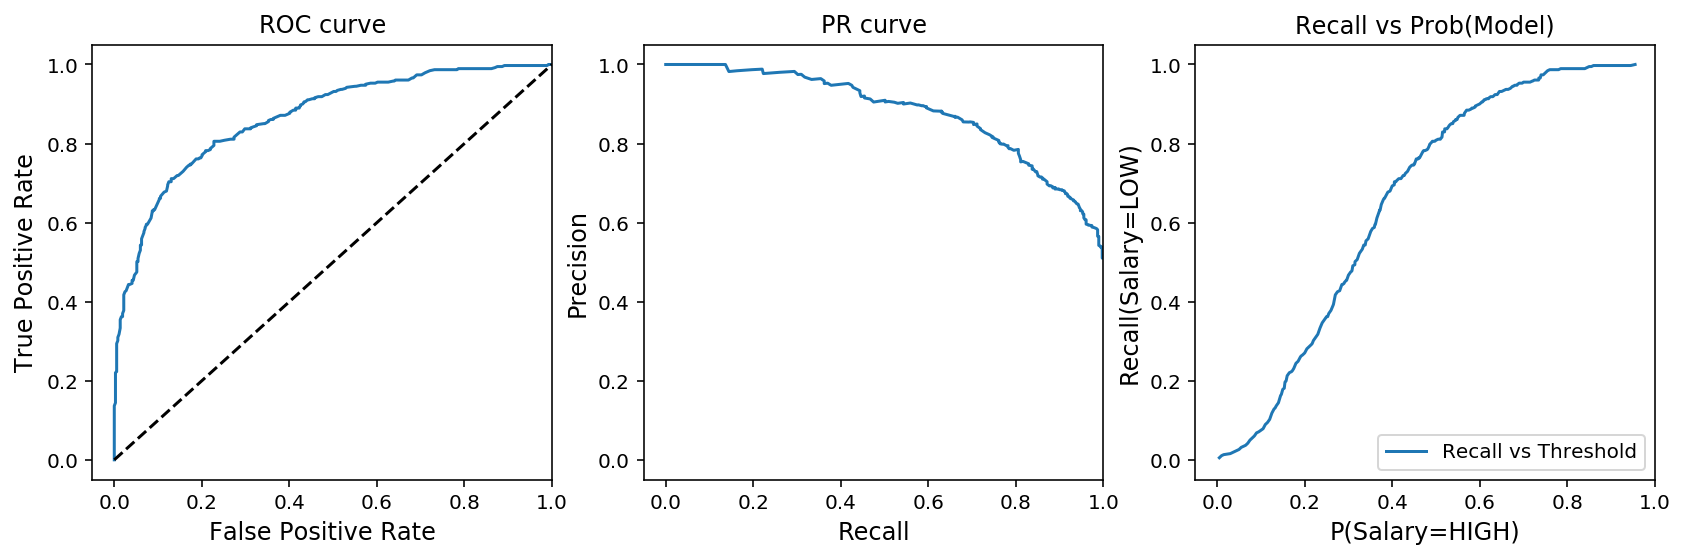

In [136]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, recall_score
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# For class LOW, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, y_pp.LOW, pos_label='LOW')
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pp.LOW, pos_label='LOW')

# Plot ROC and precision-recall curves for class LOW
fig, ax = plt.subplots(1, 3, figsize=[14, 4])

ax[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_xlim([-0.05, 1.0])
ax[0].set_ylim([-0.05, 1.05])
ax[0].set_xlabel('False Positive Rate', fontsize=12)
ax[0].set_ylabel('True Positive Rate', fontsize=12)
ax[0].set_title('ROC curve', fontsize=12)
plt.legend(loc="lower right")

ax[1].plot(recall, precision, label='PR curve')
ax[1].set_xlim([-0.05, 1.0])
ax[1].set_ylim([-0.05, 1.05])
ax[1].set_xlabel('Recall', fontsize=12)
ax[1].set_ylabel('Precision', fontsize=12)
ax[1].set_title('PR curve', fontsize=12)
plt.legend(loc="lower right")

ax[2].plot(1-threshold, recall[:-1], label='Recall vs Threshold')
ax[2].set_xlim([-0.05, 1.0])
ax[2].set_ylim([-0.05, 1.05])
ax[2].set_xlabel('P(Salary=HIGH)', fontsize=12)
ax[2].set_ylabel('Recall(Salary=LOW)', fontsize=12)
ax[2].set_title('Recall vs Prob(Model)', fontsize=12)
plt.legend(loc="lower right")

plt.show()

In [140]:
# change the scoring method below to f1-score to help your boss be confident of the model, and see what / how
# it changes (ie. replot as above as well). WILL NEED TO BINARIZE FIRST!
# Note - you want to increase f1 of LOW (may not be same as overall f1??)

from sklearn.preprocessing import Binarizer 

y_train_bin = Binarizer(salary_avg_USD.median()).fit_transform(y_train)
y_test_bin = Binarizer(y.median()).fit_transform(y_test)

for i in range(len(models)):
    gs = GridSearchCV(models[i], params[i], scoring='f1', n_jobs=2, cv=kf, verbose=1)
    gs.fit(X_train, y_train)
    print('Best params:',gs.best_params_)
    print('Cross Val Score:',gs.best_score_)
    predictions = gs.predict(X_test)
    print('Confusion Matrix:')
    print(' ')
    print(confusion_matrix(y_test, predictions))
    print('Classification Report:')
    print(' ')
    print(classification_report(y_test, predictions))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


ValueError: pos_label=1 is not a valid label: array(['HIGH', 'LOW'], dtype='<U4')

In [129]:
# Model Feature Importances:
pd.DataFrame(model.feature_importances_, index=X_summary.columns).sort_values(0,ascending=False).T

,data,analyst,isSenior,business,engineer,isLead,rating_None,isDE,isGraduate,analytics,experience,intelligence,machine,isDS,learning,search_city_Reading,isJunior,isDA,isDirector,search_city_Birmingham,team,scientist,search_city_Nottingham,role,working,lead,search_city_New+York,search_city_London,development,new,work,senior,manager,isManager,science,years,python,looking,isHead,artificial,rating_4.3,company_Harnham,cloud,search_city_Cambridge,reports,support,based,big,s,company_University of Oxford,skills,company_Linux Recruit,research,search_city_Philadelphia,using,london,position,ai,solutions,knowledge,analysis,client,isBI,including,software,advanced,deep,tools,rating_4.2,management,engineering,systems,seeking,build,responsible,digital,reporting,processing,customer,join,developer,information,time,building,marketing,models,architect,strong,key,teams,global,architecture,sql,performance,company,computer,provide,develop,technical,search_city_Edinburgh,search_city_Los+Angeles,opportunity,technology,isML,operations,large,analytical,bi,commercial,understanding,platform,salary,sales,job,project,services,clients,candidate,application,training,search_city_Denver,techniques,developing,real,technologies,leading,experienced,ability,implementation,rating_4.0,company_Inspiring Interns,statistical,level,aws,vision,use,isApprentice,rating_4.5,following,rating_5.0,rating_3.7,focus,design,database,graduate,c,projects,degree,company_Media IQ Recruitment,product,consultant,market,manage,growing,search_city_Dallas,opportunities,strategy,search_city_San+Francisco,closely,insights,financial,required,help,media,complex,warehouse,security,process,high,good,preferred,specialist,include,need,industry,order,successful,currently,sources,infrastructure,ll,expertise,associate,excel,products,k,requirements,databases,rating_3.3,exciting,quality,engineers,search_city_Portland,areas,apply,isAI,insight,mining,finance,year,e,benefits,department,hands,rapidly,creating,start,junior,post,title,web,end,proven,health,office,field,algorithms,sets,etl,excellent,candidates,enterprise,delivery,modelling,bonus,rating_4.1,processes,expert,scientists,search_city_Seattle,company_Michael Page UK,assist,plus,agency,company_Consortia,company_New York City DEPT OF HEALTH/MENTAL HYGIENE,needs,identify,predictive,search_city_Chicago,methods,create,responsibility,strategic,tableau,server,range,driven,agile,director,automation,different,background,related,multiple,ensuring,recruiting,relevant,consultancy,environment,events,company_Metrica Recruitment,managing,tech,ideal,responsibilities,rating_3.5,cyber,ensure,able,search_city_Austin,highly,service,professional,make,company_Venturi,social,talented,programming,focused,statistics,azure,future,expanding,executive,developers,g,deliver,account,drive,existing,innovative,group,improve,head,operational,maintain,customers,open,rating_3.8,google,solving,like,understand,applications,mathematics,similar,internal,implement,providing,motivated,perform,public,d,consulting,mobile,activities,testing,date,network,serve,r,uk,company_Cortex IT Recruitment,venturi,ml,analyse,learn,travel,core,program,rating_3.6,insurance,offer,variety,search,previous,crm,visualisation,individuals,hire,held,limited,platforms,company_Lead Foot Digital,company_Digital Taxonomy,operates,independent,person,power,employment,structured,scale,t,world,users,latest,rating_4.6,language,growth,problems,b,user,function,interpret,ideally,planning,analysts,rating_3.9,company_Deerfoot,warehousing,company_New York City Department of Education .,day,company_Aspire Data Recruitment,microsoft,package,search_city_Pittsburgh,analyze,record,international,established,rating_3.0,pipelines,report,computing,master,local,maintaining,organisation,company_Ampersand Consulting,company_kdr Recruitment,permanent,includes,practice,company_Northpoint Recruitment,meet,relationships,applied,devops,essential,company_Source,trends,central,employee,search_city_Phoenix,wide,designing,analysing,organization,bachel

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [142]:
## YOUR CODE HERE:

# Once model tweaked / understood...
# 1. Tableau visualisation map
# 2. NLTK conversion of NLP steps
# 3. Productionization step / piping to end it: once model / data cleaning steps identified
# 4. Then you can document all this as below, only once finished.

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 